# Overview #

Pneumonia is an infection that inflames the air sacs of one or both lungs and fills it with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills and difficulty in breathing. It is the leading infectious cause of death internationally for children under 5.

In this project, the goal is to detect pneumonia cases in chest radiographs by predicting bounding boxes of the ailment after training on sample radiographs. Pneumonia is one of many possible diseases that can occur on a chest radiograph and any given sample or test image can have >= 0 indications of pneumonia. That is, there can more >= 0 bounding boxes corresponding to pneumonia locations.

# Import classes & libraries for analysis #

In [2]:
import os
import sys

import glob
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

import utils.utils as ut

%matplotlib inline

DATASET_DIR = 'dataset'
TRAIN_IMAGES = DATASET_DIR + os.sep + 'train_images'
ANALYSIS_DIR = 'analysis'

# Download Dataset #

The dataset can be downloaded from Kaggle. Run the code below to download it.

***Note: You must accept the user agreement on the competition website! Then follow [instructions to obtain your Kaggle Credentials](https://github.com/Kaggle/kaggle-api#api-credentials).***

In [5]:
ut.download_dataset(DATASET_DIR, '<your_kaggle_username>', '<your_kaggle_api_key>')

Creating dataset directory.
  0%|                                                | 0.00/55.0 [00:00<?, ?B/s]
100%|████████████████████████████████████████| 55.0/55.0 [00:00<00:00, 48.9kB/s]
100%|█████████████████████████████████████████| 561k/561k [00:00<00:00, 778kB/s]

100%|███████████████████████████████████████| 51.8k/51.8k [00:00<00:00, 390kB/s]

100%|████████████████████████████████████████| 634k/634k [00:00<00:00, 4.49MB/s]

100%|████████████████████████████████████████| 126M/126M [00:56<00:00, 1.58MB/s]

100%|██████████████████████████████████████| 3.17G/3.17G [26:18<00:00, 1.33MB/s]

Dataset downloaded successfully.


# Pneumonia Detection Dataset #

The data for this project is organized into several files, folders and file types.

In [8]:
!ls .

dataset				    proposal.pdf      utils
pneumonia_detection_analysis.ipynb  requirements.txt


There are 4 key files and folders:

1. **train_labels.csv**: This CSV file contains the annotations for patients' chest radiographs. These are the bounding boxes. It also contains patient IDs and their corresponding labels.
2. **detailed_class_labels.csv**: This CSV file contains detailed label description for each patient ID. It can be used for more nuanced classifications of classes.
3. **train_images**: This folder contains chest radiograph images of patients. Each filename corresponds to the patient's ID.
4. **test_images**: This folder contains images that will be used to test the final model developed to detect cases in pneumonia.

Inspecting **train_labels.csv** file further:

In [4]:
# Load training labels
train_labels = pd.read_csv(os.path.join(DATASET_DIR, 'train_labels.csv'))
train_labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


Each row in the dataframe corresponds to a patient's chest radiograph. `NaN` values mean that there are no corresponding bounding boxes for a patient. This means that the chest radiograph of the patient does not indicate any case of pneumonia. This is evidenced with the corresponding `Target` value equating to 0. `x`, `y`, `width` and `height` correspond to the upper `x` coordinate, upper `y` coordinate, the `width` and `height` of the bounding boxes respectively.

It is also important to note that images with multiple bounding boxes have multiple rows in the dataset set but with the same patient ID.

### Analyzing `Target` label distribution ###

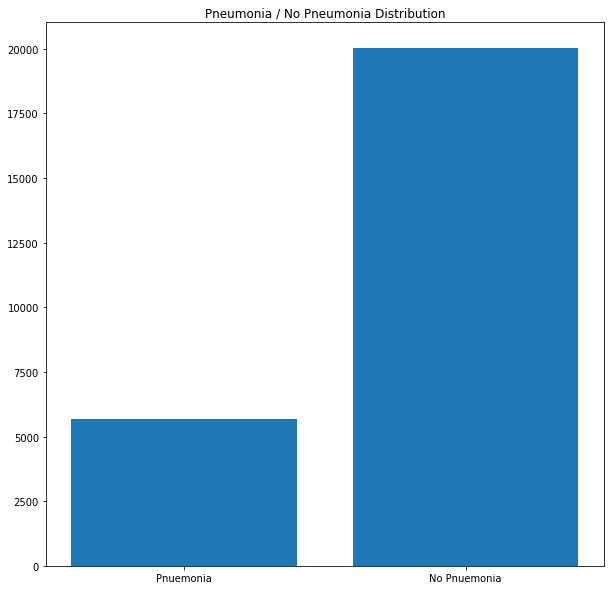

[5659, 20025]


In [5]:
def target_distrib(targets):
    """
    Count the target labels with pneumonia and no pneumonia
    
    targets: list of target labels
    """
    assert targets != None and len(targets) != 0, 'targets cannot be empty or none'
    
    pneumonia = no_pneumonia = 0
    for target in targets:
        if target == 0:
            no_pneumonia += 1
        else:
            pneumonia += 1
            
    return [pneumonia, no_pneumonia]

# Copy the train_labels and remove duplicates since duplicates 
# represent a single patient
target_labels = train_labels
target_labels = target_labels.drop_duplicates('patientId')
# target_labels.head(10)

targets = list(target_labels['Target'])
distribution = target_distrib(targets)

plt.figure(figsize=(10, 10))
plt.bar(np.arange(2), distribution)
plt.title('Pneumonia / No Pneumonia Distribution')
plt.xticks(np.arange(2), ('Pnuemonia', 'No Pnuemonia'))
plt.savefig(os.path.join(ANALYSIS_DIR, 'distribution.png'))
plt.show()

print(distribution)

There are more images free of pneumonia. We will consider a more nuanced distribution when analyzing **detailed_class_labels.csv***

### Analyzing `detailed_class_labels.csv` ###

In [6]:
# Load detailed classes
detailed_class_labels = pd.read_csv(os.path.join(DATASET_DIR, 'detailed_class_labels.csv'))
detailed_class_labels.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


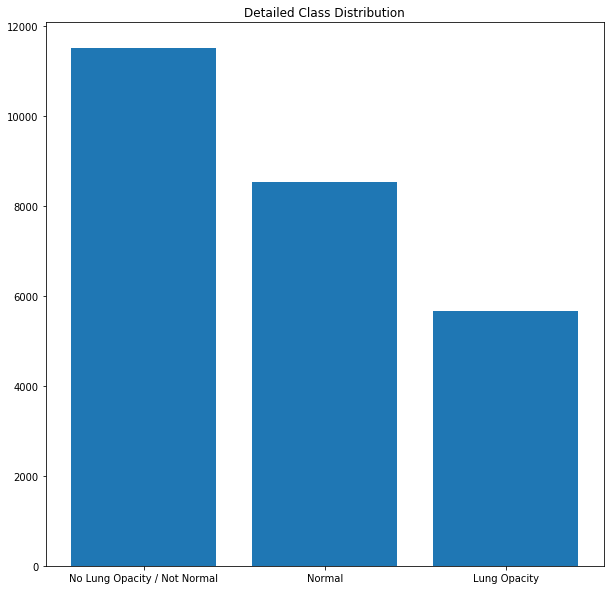

{'No Lung Opacity / Not Normal': 11500, 'Normal': 8525, 'Lung Opacity': 5659}


In [7]:
def class_distrib(classes):
    """
    Count detailed class distributions
    
    classes: details class labels dataframe
    """
    
    distribution = {}
    for _, row in classes.iterrows():
        if row['class'] not in distribution:
            distribution[row['class']] = 0
        distribution[row['class']] += 1
        
    return distribution

# Copy the detailed_class_labels and remove duplicates since duplicates 
# represent a single patient
class_labels = detailed_class_labels
class_labels = class_labels.drop_duplicates('patientId')
# class_labels.head(10)

distribution = class_distrib(class_labels)

plt.figure(figsize=(10, 10))
plt.bar(np.arange(len(distribution)), list(distribution.values()))
plt.title('Detailed Class Distribution')
plt.xticks(np.arange(len(distribution)), list(distribution.keys()))
plt.savefig(os.path.join(ANALYSIS_DIR, 'nuanced_distribution.png'))
plt.show()

print(distribution)

The bar chart makes it clear that, although there are more patients without pneumonia (lung opacity), there are more patients in that distribution with something wrong with their lungs. This could be some other form of ailment or condition.


# Exploring and visualizing images #

The images provided are of a special format known as DICOM files (`*.dcm`). They contain a combination of header metadata as well as underlying raw image arrays for pixel data. The `pydicom` library can be used to visualize these images.

*NB: Run the next two code cells several times to generate random images.*

In [37]:
patient_id = random.choice(train_labels['patientId']) # visualize a random image
dcm_file = os.path.join(TRAIN_IMAGES, patient_id+'.dcm')
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)
print('\n')
print('Shape of dicom train image: {}'.format(dcm_data.pixel_array.shape))

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.16634.1517874398.654345
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '813a9141-d54b-4fca-a46e-2499e8065495'
(0010, 0020) Patient ID                          LO: '813a9141-d54b-4fca-a46e-2499e8065495'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

The provided images have already been preprocessed. Therefore, there will be no need for any preprocessing of the dicom images. The relatively large size of the original medical images have been reduced to shape (1024 x 1024). This shape is adequate for our convolutional neural network to handle (it is also possible that a further reduced shape might also be adequate to train our network).


### Vizualizing a sample image ###

We can visualize an image using `pylab`

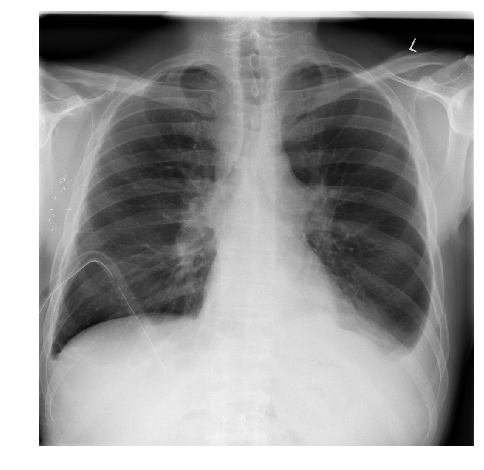

In [38]:
image = dcm_data.pixel_array
pylab.figure(figsize=(8, 8))
pylab.imshow(image, cmap=pylab.cm.gist_gray)
pylab.axis('off')
pylab.savefig(os.path.join(ANALYSIS_DIR, 'patient_cxr.png'))

### Exploring data labels ###

As already pointed out earlier, any given patient may have >= 0 boxes if there are suspicious cases on pneumonia. The CSV of train labels needs to be collapsed to a dictonary of unique entries.

In [39]:
parsed_data = ut.parse_data(TRAIN_IMAGES, train_labels)
print(parsed_data[patient_id])

{'id': '813a9141-d54b-4fca-a46e-2499e8065495', 'dicom': 'dataset\\train_images/813a9141-d54b-4fca-a46e-2499e8065495.dcm', 'label': 0, 'boxes': []}


### Visualizing bounding boxes ###

Below shows a patient with pneumonia compared with one without.

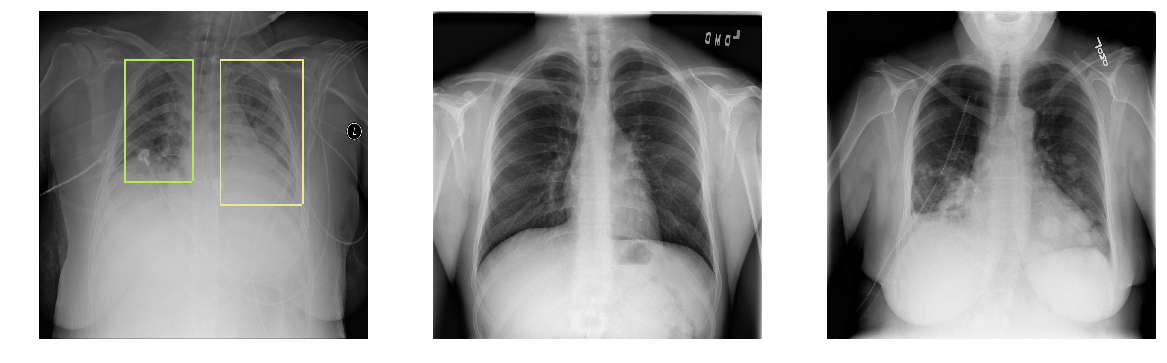

In [29]:
pylab.figure(figsize=(20, 20))
ut.draw_dicom(parsed_data['00436515-870c-4b36-a041-de91049b9ab4'], '131') # pneumonia patient
ut.draw_dicom(parsed_data['003d8fa0-6bf1-40ed-b54c-ac657f8495c5'], '132') # normal patient
ut.draw_dicom(parsed_data['0004cfab-14fd-4e49-80ba-63a80b6bddd6'], '133') # no pneumonia but still not normal patient

The three images show different patients. The patient on the left has two instance of pneumonia infection, the patient in the middle is normal and does not have pneumonia while the patient on the right, although not having pneumonia, still has something wrong with his/her lungs.